# Predicting Financial Fraud of Firms
## 1.0 Introduction

Firms report financial statements for every quarter and annual period. These statements are first reported internally by the organization, which in turn must be audited by accredited auditing firms to verify that the reports are accurate. Firms may be incentivized to create fraud within their reports for financial benefits such as taxation and value inflation. Fraudulent activity can cause massive monetary loss for investors (Hajek 2017), government organizations (Lin 2015), and individuals (Lin 2015). Fraudulent activity is also increasing (Lin 2015). This marks a growing importance for developing better ways at detecting and eliminating financial fraud.

Our analysis will try to determine if selected variables can form a model to accurately predict whether or not a firm is fraudulent given the predictor variables.

The question we want to answer is: <strong>Can we accurately predict if a firm is fraudulent or not based on its reported vs audited monetary discrepancies, money involved in misstatements, and historical monetary loss?</strong> (Determining these variables is in <strong>1.13</strong>)

The dataset that will be used to answer this question is Audit Data. Audit Data contains risk factor classifications and methods used by the external auditing firm. Specifically, the data contains reports from 777 firms from 46 different listings and 14 different sector scores. The variable that the model will be predicting is Risk. The numeric variables in this dataset and Risk are:

<ol>
    <li>Para A : Discrepancy in planned spending in Indian Rupees (in crore) (Hooda 2018)</li>
    <li>Para B : Discrepancy in unplanned spending in Indian Rupees (in crore) (Hooda 2018)</li>
    <li>Total : Sum of discrepancies in Para A and Para B and other reports in Indian Rupees (in crore) (Hooda 2018)</li>
    <li>Number : Historical Discrepancy Score (non-measured) (Hooda 2018)</li>
    <li>Money Value : Amount of money involved in misstatements (Hooda 2018)</li>
    <li>Sector : Historical risk score (non-measured) (Hooda 2018)</li>
    <li>Loss : Monetary loss suffered by a firm in the last year (Hooda 2018)</li>
    <li>History : Average monetary loss by a firm in the last 10 year (Hooda 2018)</li>
    <li>District Score : Risk score of district in last 10 years (non-measured) (Hooda 2018)</li>
    <li>Risk <strong>(predicted fct variable)</strong> : 1 if the firm has been determined to be fraudulent. 0 if not.</li>
</ol>

#### [Figure 1.0]

Some variables were not included because they were enumerations (eg. Audit ID, Location ID) or calculated risk values (eg. ARS, a determined value from machine learning (Hooda 2018))

## 1.1 Methods

### 1.11 Process

In order to answer our question, an exploration of the data will be performed in order to determine which variables are suitable for use in our analysis (This is done in <strong>1.13</strong>). We will create an initial KNN model with our predictor variables which we will use in a cross-validation in order to determine an optimum value of K for the model. This value of K will be used to create our final model.

Next, we will use the testing data to test how accurate our model is at classifying observations it has not seen. Finally, we will summarize our findings by calculating an accuracy and also displaying a confusion matrix of how well the model was able to predict Risk for the testing data.

### 1.12 Wrangling

First, we load the libraries that we need, which are tidyverse, tidymodels, repr, and GGally.

In [3]:
library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Now we want to download the data from the url. Since it is in .zip format, we have to download it before unzipping and then using read_csv(). The file "audit_risk.csv" is the one with the data that we want to use to create our classification.

In [4]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00475/audit_data.zip"
download.file(url, "audit_data.zip")
unzip("audit_data.zip")

audit_risk_data_main <- read_csv("audit_data/audit_risk.csv")

Warning message:
“Duplicated column names deduplicated: 'Score_B' => 'Score_B_1' [11]”
Parsed with column specification:
cols(
  .default = col_double(),
  LOCATION_ID = col_character()
)

See spec(...) for full column specifications.



Before we inspect the data, we should split it up into training and testing data so we are only using the training data during our training portion of the analysis. We set the seed so the split is the same everytime, then use initial_split to perform the split. Next, we extract each respective data set into a training data set and a testing data set.

In [5]:
### SET THE SEED
set.seed(18)
### DO NOT CHANGE

audit_risk_data_split <- initial_split(audit_risk_data_main, prop = 2/3, strata = Risk)
audit_risk_data_training <- training(audit_risk_data_split)
audit_risk_data_testing <- testing(audit_risk_data_split)

Firstly, we should inspect the table to check for poor data quality, tidyness, and trends. We can check the first few rows of the training data.

In [6]:
head(audit_risk_data_training, 12)

Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.89,6,0.00,0.2,0.000,10.80,0.6,6.480,10.80,6.0,⋯,0.4,0,0.2,0.0,4.4,17.5300,0.4,0.5,3.50600,1
3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5.0,⋯,0.4,0,0.2,0.0,2.0,1.4160,0.4,0.5,0.28320,0
3.89,7,1.10,0.4,0.440,7.41,0.4,2.964,8.51,5.0,⋯,0.4,0,0.2,0.0,3.2,31.7740,0.4,0.5,6.35480,1
3.89,8,8.50,0.6,5.100,12.03,0.6,7.218,20.53,5.5,⋯,0.4,0,0.2,0.0,4.2,18.0340,0.4,0.5,3.60680,1
3.89,8,8.40,0.6,5.040,11.05,0.6,6.630,19.45,5.5,⋯,0.4,0,0.2,0.0,4.2,17.2060,0.4,0.5,3.44120,1
3.89,8,3.98,0.6,2.388,0.99,0.2,0.198,4.97,5.0,⋯,0.4,0,0.2,0.0,2.4,4.3720,0.4,0.5,0.87440,0
3.89,8,5.43,0.6,3.258,10.77,0.6,6.462,16.20,5.0,⋯,0.4,0,0.2,0.0,3.6,12.0040,0.4,0.5,2.40080,1
3.89,8,5.47,0.6,3.282,7.63,0.4,3.052,13.10,5.0,⋯,0.4,1,0.4,0.4,3.6,14.3920,0.8,0.5,5.75680,1
3.89,8,1.09,0.4,0.436,0.35,0.2,0.070,1.44,5.0,⋯,0.4,0,0.2,0.0,2.2,1.9060,0.4,0.5,0.38120,0


#### [Table 1.12]. Legend: See [Figure 1.0]

The data appears to be tidy in the columns we can see. Each column is one variable, each row is one observation, and each cell has exactly one value. Out of the 12 rows we are showing, there are no NA values, but let's check to make sure there aren't a massive amount of NAs hiding:

In [7]:
nrow(na.omit(audit_risk_data_training))
nrow(audit_risk_data_training)

[1] 517

[1] 518

The data seems to be of high quality! There is only one row with missing data. Since this observation could just be an irrelevant variable, we should filter out rows with NA values after we choose our predictors so we can keep as many observations as possible. Since we are predicting Risk through classification, we should convert that column to a factor. Let's also do the same for the testing data:

In [8]:
audit_training <- mutate(audit_risk_data_training, Risk = as_factor(Risk))
audit_testing <- mutate(audit_risk_data_testing, Risk = as_factor(Risk))

head(select(audit_training, Risk), 1)

Risk
<fct>
1


### 1.13 Exploring the Data through Tables to Inspect Quality, Inspect Trends, and Determine Variables

There are too many column names. Let's examine all the column names and match them with the variables described in the introduction. There are many columns here that are never referenced in the research articles we used, so we can remove them since they are irrelevant to our analysis. Let's check the column names.

In [9]:
colnames(audit_training)

[1] "Sector_score"   "LOCATION_ID"    "PARA_A"         "Score_A"       
 [5] "Risk_A"         "PARA_B"         "Score_B"        "Risk_B"        
 [9] "TOTAL"          "numbers"        "Score_B_1"      "Risk_C"        
[13] "Money_Value"    "Score_MV"       "Risk_D"         "District_Loss" 
[17] "PROB"           "RiSk_E"         "History"        "Prob"          
[21] "Risk_F"         "Score"          "Inherent_Risk"  "CONTROL_RISK"  
[25] "Detection_Risk" "Audit_Risk"     "Risk"

Most of these column names can seemingly be match up with our introduction. We should remove the ones that cannot be matched, or ones that cannot be found in the data but are in our research articles. For example, one of the articles and our introduction mention a Loss variable (Hooda 2018) which is no where to be seen in the data. The only variable similar in name is District_Loss, which refers to something else. The variables we will keep and consider for our model are:
- PARA_A
- PARA_B
- TOTAL
- numbers
- Money_Value
- History
- Risk
- Sector_score.

Notably, we are missing two variables that we originally wanted to inspect for worthiness in our model. These are Loss and District Score. Loss, on inspection of the description, is not an important variable to consider because History is a better form of Loss. Loss refers to monetary loss in the last year, while History refers to monetary loss in the last 10 years. The Loss variable could be somewhat random, while History would be consistent as it is over a longer period of time. Hence, we can discard Loss.

District Score is a calculated value. This would not be a great variable to include because it would have to be calculated before the model could be used. Hence, we can discard District Score.

We can select the columns we want to consider and display some rows to examine any trends:

In [10]:
audit_consider <- audit_training %>% select(PARA_A, PARA_B, TOTAL, numbers, Money_Value, History, Risk, Sector_score)

head(audit_consider, 12)

PARA_A,PARA_B,TOTAL,numbers,Money_Value,History,Risk,Sector_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
0.00,10.80,10.80,6.0,11.750,0,1,3.89
0.00,0.08,0.08,5.0,0.000,0,0,3.89
1.10,7.41,8.51,5.0,44.950,0,1,3.89
8.50,12.03,20.53,5.5,7.790,0,1,3.89
8.40,11.05,19.45,5.5,7.340,0,1,3.89
3.98,0.99,4.97,5.0,1.930,0,0,3.89
5.43,10.77,16.20,5.0,4.420,0,1,3.89
5.47,7.63,13.10,5.0,10.430,1,1,3.89
1.09,0.35,1.44,5.0,0.000,0,0,3.89


#### [Table 1.13]. Legend: See [Figure 1.0]

From Table 1.13, it is clear that TOTAL, Money_Value, PARA_A, and PARA_B have a relationship with Risk, indicating that these could be possible variables to predict Risk. All the observations with Risk = 1 have a TOTAL >= 8.51 while the max of TOTAL for observations with Risk = 0 in this table is 4.97.

Another thing of notability is the values for PARA_A, PARA_B, and TOTAL. In the rows, TOTAL appears to be the sum of PARA_A and PARA_B. Let's examine this further by creating a new column called AB that is the sum of PARA_A and PARA_B. Then we should check how many rows have TOTAL and AB not equal. Since we are comparing decimals that are vulnerable to floating point error we should compare with an epsilon of 0.1.

In [11]:
audit_total_ne_aplusb <- audit_consider %>%
mutate(AB = PARA_A + PARA_B, equal = (abs(AB - TOTAL) <= 0.1)) %>%
filter(equal == FALSE)

head(audit_total_ne_aplusb, 12)

PARA_A,PARA_B,TOTAL,numbers,Money_Value,History,Risk,Sector_score,AB,equal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<lgl>
20.65,0,0,6,397.31,1,1,15.56,20.65,FALSE


#### [Table 1.131]. Legend: See [Figure 1.0]

It seems like TOTAL is simply the sum of PARA_A and PARA_B. There is only one observation that has a difference abs(AB - TOTAL) greater than 0.1. This could be an error in the observation or it could be an obscure case. Based on this exploratory analysis of the data, we can conclude that TOTAL is the sum of PARA_A and PARA_B. When inspecting Para A, Para B, and Total, they all represent discrepancies in reported spending vs audited spending. Discrepancies in reported vs audited spending would be extremely valuable to determine if a firm is fraudulent because false reporting of money spending would likely indicate suspicious activity. Hence, we should include a variable that describes discrepancy in spending. Since Total includes Para A, Para B, and other discrepancies, it makes more sense to only include Total and remove Para A and Para B as predictor variables.

#### Visualizing the Training Data to Detect Trends and Find Relevant Variables

#### Money_Value

Next let's look at Money_Value, another one of the numbers that seemed to have some sort of relationship with Risk. In Table 1.13, high Money_Value values correspond with a Risk value of 1. We can create two histograms, one with the distributions of Money_Value for observations of Risk = 1, and the other with the distributions of Money_Value for observations of Risk = 0.

We can do this by using facet_grid() to create 2 separate histogram distribution plots of Money_Value for Risk == 0 and Risk == 1.

Warning message:
“Transformation introduced infinite values in continuous x-axis”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 217 rows containing non-finite values (stat_bin).”


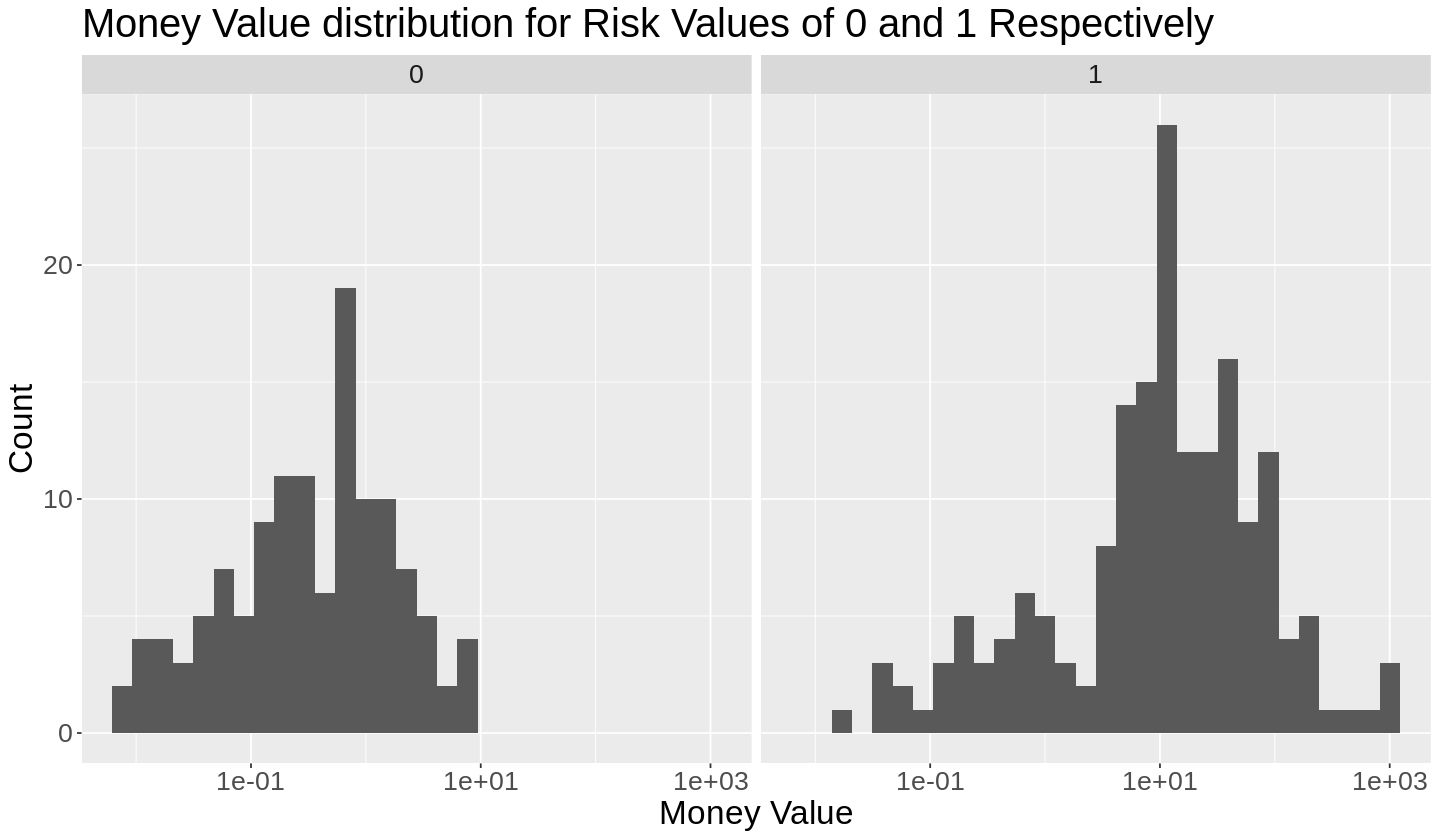

In [12]:
options(repr.plot.width = 12, repr.plot.height = 7)

money_value_plot <- audit_consider %>%
ggplot(aes(x = Money_Value)) +
facet_grid(. ~ Risk) +
geom_histogram() +
labs(x = "Money Value", y = "Count") +
ggtitle("Money Value distribution for Risk Values of 0 and 1 Respectively") +
theme(text = element_text(size = 20)) +
scale_x_log10()

money_value_plot

#### [Figure 1.132]. Money Value: Amount of Money involved in misstatements (Hooda 2018)

From Figure 1.132, it's pretty clear that Money Values associated with a Risk value of 1 are much higher on average than Money Values associated with a Risk value of 0. The histogram for Risk == 1 is shifted farther to the right and has a center of around 10, while the hitogram for Risk == 0 has a center of between 0.1 and 1.

#### TOTAL

We haven't done this for TOTAL yet, so let's do that:

Warning message:
“Transformation introduced infinite values in continuous x-axis”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 64 rows containing non-finite values (stat_bin).”


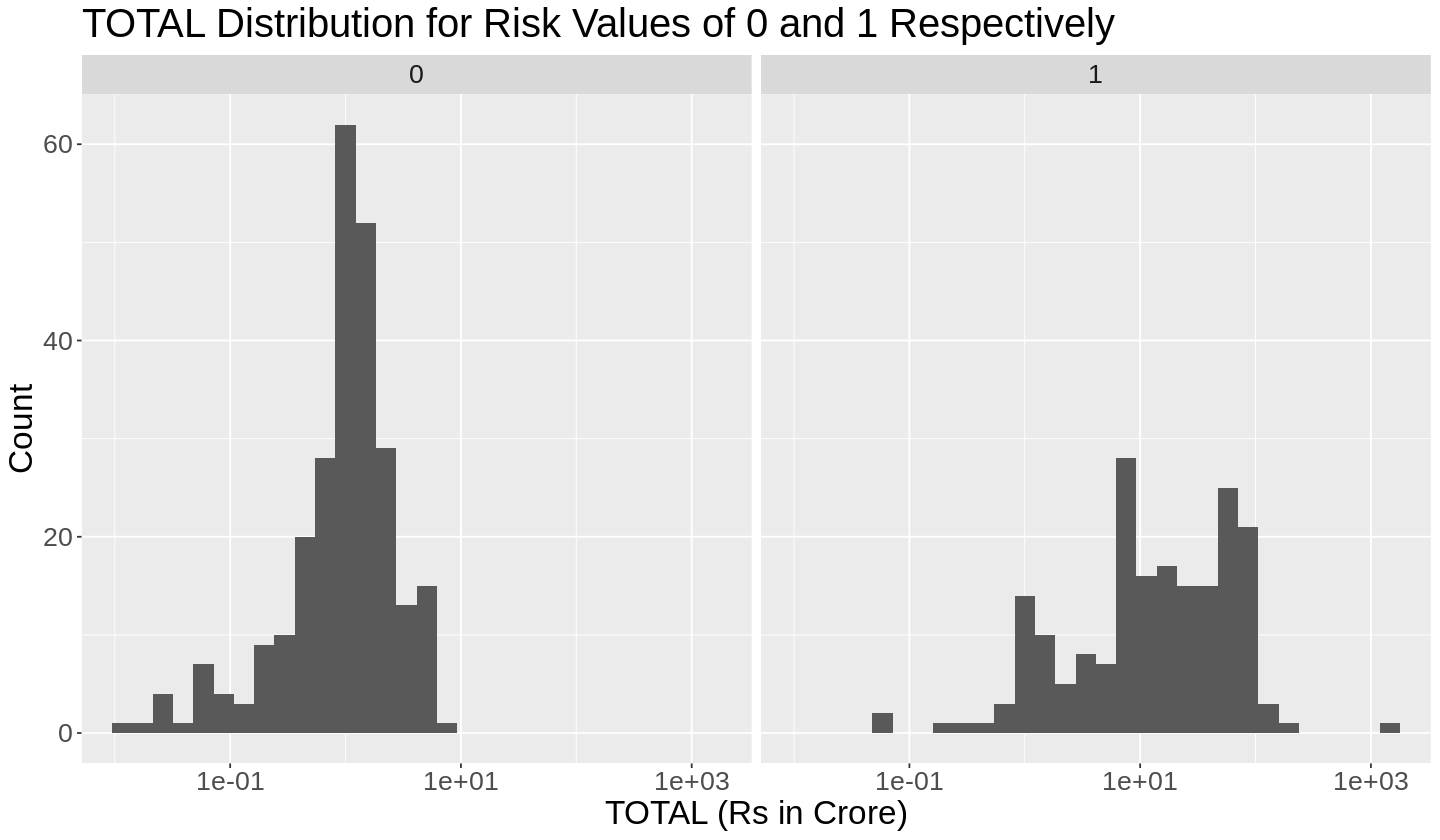

In [13]:
options(repr.plot.width = 12, repr.plot.height = 7)

money_value_plot <- audit_consider %>%
ggplot(aes(x = TOTAL)) +
facet_grid(. ~ Risk) +
geom_histogram() +
labs(x = "TOTAL (Rs in Crore)", y = "Count") +
ggtitle("TOTAL Distribution for Risk Values of 0 and 1 Respectively") +
theme(text = element_text(size = 20)) +
scale_x_log10()

money_value_plot

#### [Figure 1.133]. TOTAL: Discrepencies in planned and unplanned spending

From Figure 1.133, there also appears to be an trend. There are much more TOTAL values greater than 0 if Risk == 1. We can quantitavely determine if they are good variables by checking their mean for Risk == 0 and Risk == 1. Let's create a mean, min, max, and sd table for each of the variables in Table 1.13, separated by Risk value, to help determine if they would be a good candidate or not:

# Maybe more info here

In [14]:
bind_rows(filter(audit_consider, Risk == 0) %>%
select(-Risk) %>%
map_df(mean, na.rm = TRUE) %>%
mutate(Stat = "Mean", Risk = 0) %>%
bind_rows(audit_consider %>%
         filter(Risk == 0) %>%
         select(-Risk) %>%
         map_df(sd, na.rm = TRUE) %>%
         mutate(Stat = "SD", Risk = 0)),
          
filter(audit_consider, Risk == 0) %>%
          select(-Risk) %>%
          map_df(min, na.rm = TRUE) %>%
          mutate(Stat = "Min", Risk = 0),
          
filter(audit_consider, Risk == 0) %>%
          select(-Risk) %>%
          map_df(max, na.rm = TRUE) %>%
          mutate(Stat = "Max", Risk = 0),
          
          filter(audit_consider, Risk == 1) %>%
          select(-Risk) %>%
          map_df(min, na.rm = TRUE) %>%
          mutate(Stat = "Min", Risk = 1),
          
filter(audit_consider, Risk == 1) %>%
          select(-Risk) %>%
          map_df(max, na.rm = TRUE) %>%
          mutate(Stat = "Max", Risk = 1),

filter(audit_consider, Risk == 1) %>%
select(-Risk) %>%
map_df(mean, na.rm = TRUE) %>%
mutate(Stat = "Mean", Risk = 1) %>%
bind_rows(audit_consider %>%
         filter(Risk == 1) %>%
         select(-Risk) %>%
         map_df(sd, na.rm = TRUE) %>%
         mutate(Stat = "SD", Risk = 1)))

PARA_A,PARA_B,TOTAL,numbers,Money_Value,History,Sector_score,Stat,Risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
0.7248408,0.4493433,1.174184,5.00159236,0.3856997,0.003184713,26.792197,Mean,0
0.9624982,0.8833369,1.327482,0.02821663,1.0864456,0.056433265,25.742227,SD,0
0.0000000,0.0000000,0.000000,5.00000000,0.0000000,0.000000000,1.850000,Min,0
5.2000000,7.3700000,7.370000,5.50000000,8.2100000,1.000000000,59.850000,Max,0
0.0000000,0.0000000,0.000000,5.00000000,0.0000000,0.000000000,1.850000,Min,1
85.0000000,1264.6300000,1268.910000,6.50000000,935.0300000,9.000000000,59.850000,Max,1
5.6920127,27.8664706,33.457258,5.12254902,43.3901471,0.284313725,8.323578,Mean,1
9.7573038,91.6450063,92.690083,0.27125211,123.5624716,0.858196654,15.807394,SD,1


#### [Table 1.134]. Legend: See [Figure 1.0]

The means of TOTAL for Risk == 1 and Risk == 0 vary greatly. The mean TOTAL for Risk == 0 is about 1, but it is ~33 for Risk == 1. This supports our choice of TOTAL as a predictor variable because it indicates that TOTAL can be used to determine if a firm is fraudulent or not. Same with Money_Value. The mean for Risk == 0 is about 0.5, while the mean for Risk == 1 is about 43. Using the same reasoning, we can conclude that these two variables are good for our model.

So far, we have ruled out PARA_A and PARA_B and chosen TOTAL and Money_Value. That leaves these possible predictor variables:

- numbers
- Sector_score
- History

#### numbers and Sector_score

Although both numbers and Sector_score appear to be possible predictors, they are both unmeasured quantities. The variable, "numbers," refers to historical discrepancy score, which is non-measured. Sector_score was determined by analysis (Hooda 2018). This rules both of them out because our model would be more practical if these values did not need to be included.

#### History

Now we can consider if we want to include History as a predictor variable. History could be valuable to our analysis because a fraudulent firm would likely suffer losses on record because the firm has to commit fraud in order to prevent catastrophic loss, or the firm reports losses when in fact the money went somewhere else. In addition, a firm deemed suspicous, and therefore possibly fraudulent, would be more likely to suffer losses since investors and other business people would be less inclined to work with the firm.

Table 1.134 supports adding History as a variable. For Risk == 0, History has a mean of ~0.003 and does not vary by much, only having an SD of ~0.056. In contrast, History for Risk == 1 has a mean of ~0.28 and an SD of ~0.86. History score would be a good predictor to include in our model.

We have finally considered all the possible predictors and chosen three for the model.

#### Summary of Chosen Variables:

To summarize, these are the variables that we will use to create our KNN classification model:

<strong>1. History : Average monetary loss by a firm in the last 10 years (Hooda 2018)</strong>

This was chosen because of its relationship to Risk in Table 1.134. Also, it is a measured quantity which can be determined from past audits. It describes loss which can be logically related to financial fraud. Hence, it is a strong choice for determining Risk.

<strong>2. Total : Sum of discrepancies in Para A and Para B Indian Rupees (in Rs crore)</strong>

This was also chosen because of its relationship to Risk in Table 1.134. It is a measured quantity and describes discrepancies in reported vs audited spending, which is instrumental in determing fraud.

<strong>3. Money Value : Amount of money involved in misstatements (Hooda 2018)</strong>

Also chosen for its relationship to Risk in Table 1.134. Measured quantity. Describes money involved in misstatements which should correlate with fraud because fraudulent companies may be likely to falsify money in statements.

<strong>4. Risk : the predicted variable. Factor that is either one or zero. One indicates fraud and zero indicates that the firm has been determined to be non-fraudulent.</strong>

Before we start the analysis, let's make sure that the number of observations with Risk == 1 and Risk == 0 are somewhat porportional so that we have enough of both to train our model:

In [15]:
audit_risk_data_count <- audit_risk_data_training %>%
group_by(Risk) %>%
summarize(n = n())

audit_risk_data_count

`summarise()` ungrouping output (override with `.groups` argument)



Risk,n
<dbl>,<int>
0,314
1,204


#### [Figure 1.135]. Risk: If a firm has been determined to be fraudulent (1) or not (0). n: the amount of observations with the respective Risk value.

We have about 200 observations with Risk == 1, and about 300 observations with Risk == 0. This should be enough observations, so we don't have to do any upsampling during our analysis.

## 1.2 Starting the Analysis

### 1.21 Creating our Specs and Recipes

We will use K nearest neighbours classification from tidymodels in order to create our classification model. Firstly, we have to find an optimum value of K by cross validation for each K from 1 to 50. To do this we will create a KNN spec that uses tune() for the number of neighbors and set the engine to KNN and the mode to classification. This spec will be used only to determine the value of K. After determining the new value of K, we will create a new spec that uses the final value of K instead of tune().

In [17]:
set.seed(999998)

audit_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("classification")

Now we will create a recipe for our data. The predicted variable is Risk and the predictors are Money_Value, TOTAL, and History, so we put that as the first argument of recipe().

We should standardize the data because the scales for the variables are very different. For example, History is on a scale from about 0 to ~9, while TOTAL is on a scale of 0 to ~1260. If we did not standardize, then History would have barely any effect because both the other predictors would have a substantially larger effect on the outcome of the classification. Hence, we add the steps for centering and scaling to the recipe.

In [18]:
set.seed(50)

audit_training_recipe <- recipe(Risk ~ Money_Value + History + TOTAL, audit_training) %>%
step_center(all_predictors()) %>%
step_scale(all_predictors())

Our final step before we combine these steps into a workflow is to create the vfold_cv object. We will use C = 5 folds and K values from 1 to 50. The range for K was arbitrarily chosen. If our visualization for the accuracies of various k's shows that there may lie an optimum value of K past 50, then we could have to retry with some larger values of K. First we create a variable named gridvals that is a column of integers from 1 to 50 inclusive. The name of the column is "neighbors".

Then, we can create our vfold_cv object. We specify our C = 5 folds value and then pass Risk as the strata.

In [19]:
set.seed(1001)

gridvals <- tibble(neighbors = 1:50)
audit_vfold <- vfold_cv(audit_training, C = 5, strata = Risk)

### 1.22 Tuning

Finally we can combine the spec, recipe, and vfold_cv object in order to do a 5 fold cross validation. Then we will collect the metrics for each K value from 1 to 50 and order them by the accuracy to find the K with the highest accuracy.

First, we will combine the model and the recipe we created. Then we will use tune_grid() to perform the cross validation for our vfold_cv object that we created earlier and our gridvals tibble from the code block directly above.

In [20]:
set.seed(1015)

audit_training_fit <- workflow() %>%
add_model(audit_knn_spec) %>%
add_recipe(audit_training_recipe) %>%
tune_grid(resamples = audit_vfold, grid = gridvals)

x Fold04: model 1/1 (predictions): Error: Problem with `mutate()` input `.row`.
[...



The collect_metrics can be used on audit_training_fit to extract the statistics for each value of K. We will use collect_metrics() and then filter for accuracy since that is the statistic we are interested in.

We will plot the accuracy vs the values of K in order to visually determine which K has the highest accuracy. K values will be on the x axis (stepped by 2), and the mean accuracy of each model with their respective K value on the y axis:

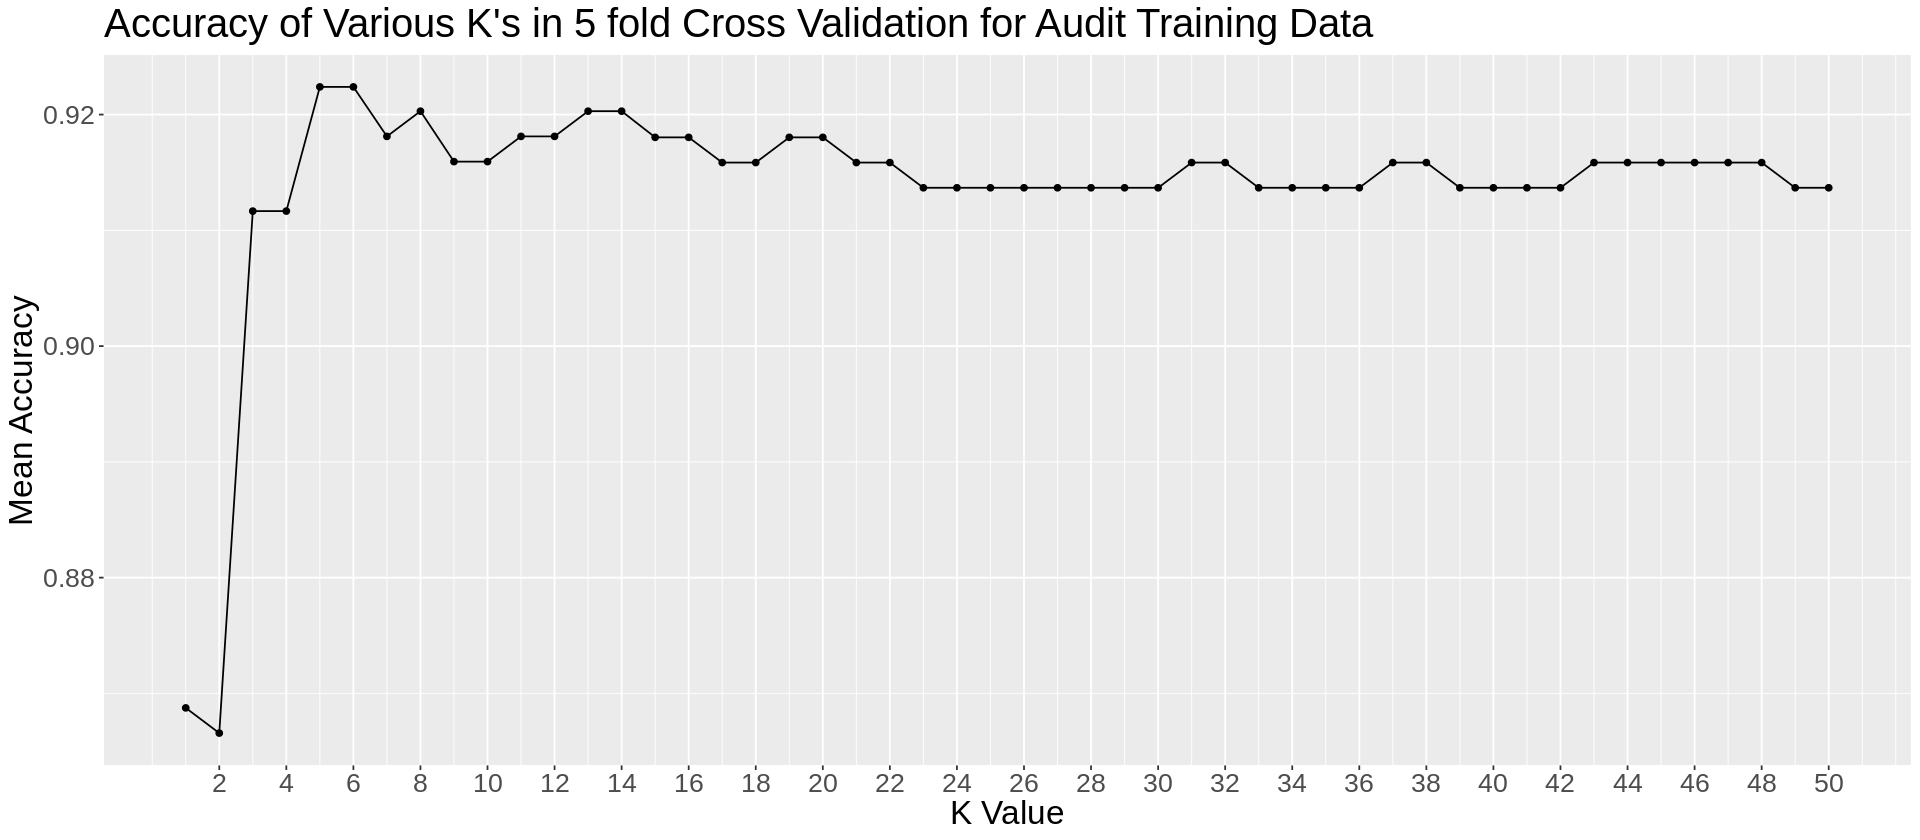

In [21]:
set.seed(26)

options(repr.plot.width = 16)

audit_training_metrics <- collect_metrics(audit_training_fit) %>%
filter(.metric == "accuracy")

audit_training_k_plot <- audit_training_metrics %>%
ggplot(aes(x = neighbors, y = mean)) +
geom_point() +
geom_line() +
labs(x = "K Value", y = "Mean Accuracy") +
theme(text = element_text(size = 20)) +
ggtitle("Accuracy of Various K's in 5 fold Cross Validation for Audit Training Data") +
scale_x_continuous(breaks = 2 * c(1:25))

audit_training_k_plot

#### [Figure 1.22]. K Value: The K value for each model. Mean Accuracy: The average accuracy of predicted vs truth in the cross-validation.

Earlier in the analysis, in 1.21, we stated that we arbitrarily chose the range for K at 1 to 50. It doesn't appear that accuracy will increase past K = 50, so we will keep K = 5 as our optimum K value.

Judging from the graph, it appears that we have an optimum K at 5. However, we should still pick the K with the highest accuracy by sorting the metrics by accuracy descending and then pulling the K value from the head of the data set:

In [22]:
audit_final_k <- audit_training_metrics %>%
arrange(desc(mean)) %>%
select(neighbors) %>%
head(1) %>%
pull()

paste("Final K Value:  K = ", audit_final_k)
audit_final_k_acc <- audit_training_metrics %>%
filter(neighbors == audit_final_k) %>%
select(mean) %>%
pull()

paste("Accuracy: ", audit_final_k_acc * 100, "%")

[1] "Final K Value:  K =  5"

[1] "Accuracy:  92.2390759238706 %"

We arrive at a K value of 5 with an accuracy of around 92.2%, which is fairly high. Since we used cross validation to determine our K and test our model for K=5, we should have a similar accuracy value for the testing data. Next, we will create our model using the determined K value.

The same recipe can be used from earlier, as we still want to create the model with the training data rather than the testing data. We will create a new spec because we want to use our specific K value of 5 rather than tune().

The model and recipe are combined together, and then the model is fit onto the training data, creating our final fit that we can use to predict the Risk factor.

In [23]:
set.seed(1009)

audit_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = audit_final_k) %>%
set_engine("kknn") %>%
set_mode("classification")

audit_final_fit <- workflow() %>%
add_recipe(audit_training_recipe) %>%
add_model(audit_final_spec) %>%
fit(data = audit_training)

## 1.3 Testing the Model on the Testing Data

### 1.31 Predicting

Our final model has been created with the training data. Let's predict our testing data and produce the table to see roughly how accurate our model is:

In [24]:
set.seed(992)

audit_tested <- bind_cols(audit_testing %>% select(Risk), predict(audit_final_fit, audit_testing))

head(audit_tested, 12)

Risk,.pred_class
<fct>,<fct>
1,1
0,0
0,0
0,0
1,1
1,1
1,1
0,0
1,1


#### [Table 1.31]. Risk: The predicted class, whether or not a firm is considered fraudulent. .pred_class: the predicted class based on the model.

From Table 1.31, it appears that our model has done a pretty good job of predicting whether or not a firm is fraudulent based on the predictor variables. Next, let's visualize our results.

### 1.32 Results

To determine the accuracy of our model, we can use metrics() on audit_tested. After using metrics(), let's filter for only accuracy since that's the only statistic we are interested in seeing.

In [29]:
audit_final_metrics <- metrics(audit_tested, truth = Risk, estimate = .pred_class) %>%
filter(.metric == "accuracy")

audit_final_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9263566


#### [Table 1.32]. .metric: the type of metric measured. .estimator: binary because we had exactly two classes. .estimate: our accuracy.

The final accuracy comes out as about 92.6%. The accuracy for the cross validation depicted in Figure 1.22 is very similar at 92.2%.

Let's investigate further by checking the confusion matrix to see if the model tended to falsely predict Risk == 0 as Risk == 1 or Risk == 1 as Risk == 0. We can use conf_mat with the same arguments as we did for Table 1.32.

In [30]:
audit_final_mat <- conf_mat(audit_tested, truth = Risk, estimate = .pred_class)

audit_final_mat

          Truth
Prediction   0   1
         0 155  17
         1   2  84

#### [Figure 1.31]. Truth: Risk == 0 or Risk == 1. Prediction: Risk == 0 or Risk == 1. Diagonal: The amount of predictions that had a truth equal to truth and a prediction equal to prediction.

Interestingly, it appears that there were many more predictions that were false negatives. There were 17 firms determined to be fraudulent by the data but not detected as fraudulent by our KNN classification model. However, there were only 2 firms determined to be non-fraudulent by the data but detected as fraudulent by our KNN model.

This could be explained by some variable that indicates fraud missing from our model. One possible problem with our model is the lack of non-monetary variables involved. All three of our variables involve quantitative measures of money, but fraud does not necessarily only encapsulate falsification with respect to money. If employee count or location count were options for variables, they could also be predictors that do not involve money. Fraudulent institutions might have less employees and only one headquarters.

## 1.4 Outcomes and Significance

[...]

## 1.5 References

Audit Data Set: https://archive.ics.uci.edu/ml/datasets/Audit+Data

Citation Request for Audit Data Set: "This research work is supported by Ministry of Electronics and Information Technology (MEITY), Govt.of India"

Reference format: [First name, Middle name(s), Last name. First Name, Middle name(s), Last Name...etc.] Title. Year of publication. \<link to article\>

eg. Joe, Jones. Google. 1998. www.google.ca

Citation format: (\<Last name of first author\> \<Year of publication\>)

eg. (Obama 1998)

[Chi-Chen, Lin. An-An, Chiu. Shaio, Yan, Huang. David, C., Yen.] Detecting the financial statement fraud: The analysis of the differences between data mining techniques and experts’ judgments. 2015. https://doi.org/10.1016/j.knosys.2015.08.011

[Nishtha, Hooda. Seema, Bawa. Prashant, Singh, Rana.] Fraudulent Firm Classification: A Case Study of an External Audit. 2018. https://doi.org/10.1080/08839514.2018.1451032 => Non pay-walled link:https://www.researchgate.net/publication/323655455_Fraudulent_Firm_Classification_A_Case_Study_of_an_External_Audit

[Petr, Hajek. Roberto, Henriques.] Mining corporate annual reports for intelligent detection of financial statement fraud – A comparative study of machine learning methods. 2017. https://doi.org/10.1016/j.knosys.2017.05.001

[Zabihollah, Rezaee.] Causes, consequences, and deterence of financial statement fraud. 2002.
https://doi.org/10.1016/S1045-2354(03)00072-8